# Regression with a Crab Age

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from tqdm.auto import tqdm
import math
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
import warnings
warnings.filterwarnings('ignore')


from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import numpy as np # linear algebra
import pandas as pd # data processing
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score , mean_absolute_error
import warnings
warnings.filterwarnings('ignore')



In [2]:
# load data
df = pd.read_csv("/kaggle/input/playground-series-s3e16/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e16/test.csv")

# Helper Functions

In [3]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [4]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

In [5]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

In [6]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

In [7]:
def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

In [8]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # print(f"Observations: {dataframe.shape[0]}")
    # print(f"Variables: {dataframe.shape[1]}")
    # print(f'cat_cols: {len(cat_cols)}')
    # print(f'num_cols: {len(num_cols)}')
    # print(f'cat_but_car: {len(cat_but_car)}')
    # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


In [9]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [10]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
  quantile1 = dataframe[col_name].quantile(q1)
  quantile3 = dataframe[col_name].quantile(q3)
  iqr= quantile3 - quantile1
  up = quantile3 + 1.5 * iqr
  low = quantile1 - 1.5 * iqr
  return low, up

def check_outlier(dataframe, col_name):
  low_limit, up_limit = outlier_thresholds(dataframe, col_name)
  if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
      return True
  else:
      return False

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


In [11]:
def objective(trial):
    lgbm_params = {
        "max_depth": trial.suggest_int("max_depth", 2, 30),
        "early_stopping_round": trial.suggest_int("early_stopping_rounds", 2, 300),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.2),
        "subsample": trial.suggest_float("subsample", 0.5, 1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1),
        "num_iterations": trial.suggest_int("num_iterations", 50, 2500),
        "num_leaves": trial.suggest_int("num_leaves", 10, 500),
        "n_jobs": -1,
        "random_state": 41,
        "verbosity": -99
    }
    
    lgbm_model = LGBMRegressor(**lgbm_params)
    lgbm_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric="mae", verbose=False)
    
    y_pred = lgbm_model.predict(X_test)
    score = mean_absolute_error(y_true=y_test, y_pred=y_pred)
    return score

# 1.EDA

In [12]:
check_df(df)

##################### Shape #####################
(74051, 10)
##################### Types #####################
id                  int64
Sex                object
Length            float64
Diameter          float64
Height            float64
Weight            float64
Shucked Weight    float64
Viscera Weight    float64
Shell Weight      float64
Age                 int64
dtype: object
##################### Head #####################
   id Sex  Length  Diameter  Height     Weight  Shucked Weight  \
0   0   I  1.5250    1.1750  0.3750  28.973189       12.728926   
1   1   I  1.1000    0.8250  0.2750  10.418441        4.521745   
2   2   M  1.3875    1.1125  0.3750  24.777463       11.339800   
3   3   F  1.7000    1.4125  0.5000  50.660556       20.354941   
4   4   I  1.2500    1.0125  0.3375  23.289114       11.977664   

   Viscera Weight  Shell Weight  Age  
0        6.647958      8.348928    9  
1        2.324659      3.401940    8  
2        5.556502      6.662133    9  
3       10.9

In [13]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

     Sex      Ratio
M  27084  36.574793
I  23957  32.352028
F  23010  31.073179
##########################################


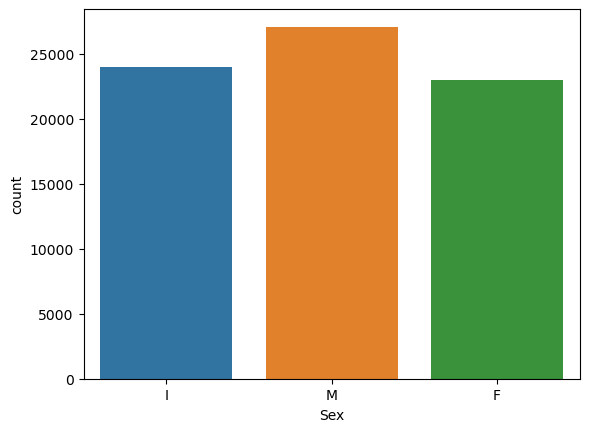

In [14]:
for col in cat_cols:
    cat_summary(df, col,plot=True)

count    74051.000000
mean     37025.000000
std      21376.826729
min          0.000000
5%        3702.500000
10%       7405.000000
20%      14810.000000
30%      22215.000000
40%      29620.000000
50%      37025.000000
60%      44430.000000
70%      51835.000000
80%      59240.000000
90%      66645.000000
95%      70347.500000
99%      73309.500000
max      74050.000000
Name: id, dtype: float64


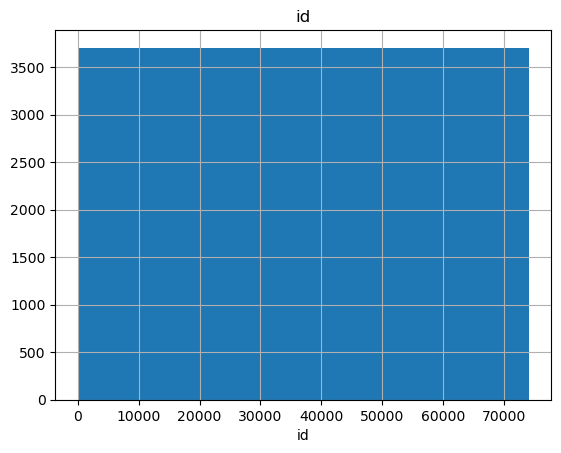

count    74051.000000
mean         1.317460
std          0.287757
min          0.187500
5%           0.737500
10%          0.900000
20%          1.087500
30%          1.200000
40%          1.300000
50%          1.375000
60%          1.437500
70%          1.500000
80%          1.562500
90%          1.625000
95%          1.675000
99%          1.787500
max          2.012815
Name: Length, dtype: float64


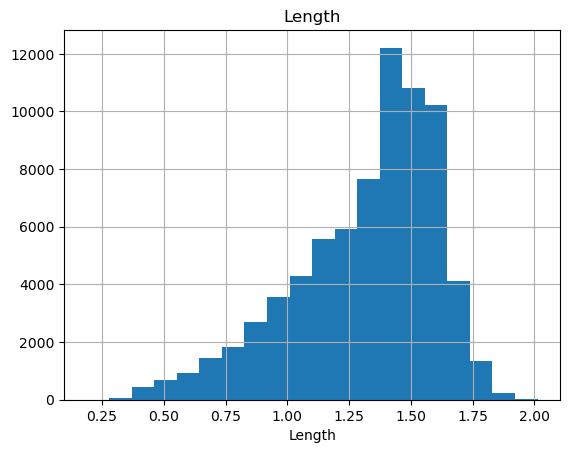

count    74051.000000
mean         1.024496
std          0.237396
min          0.137500
5%           0.550000
10%          0.675000
20%          0.837500
30%          0.937500
40%          1.000000
50%          1.075000
60%          1.125000
70%          1.187500
80%          1.225000
90%          1.287500
95%          1.312500
99%          1.412500
max          1.612500
Name: Diameter, dtype: float64


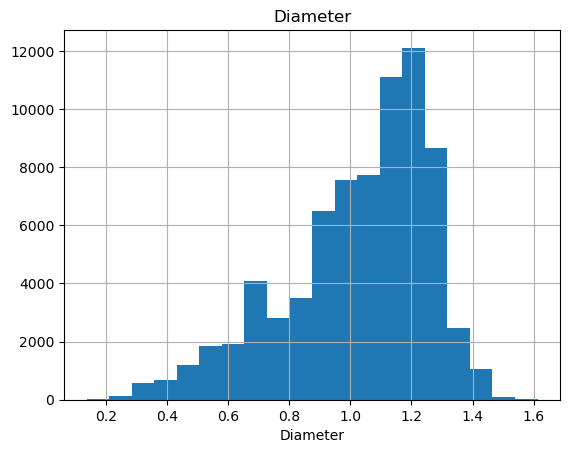

count    74051.000000
mean         0.348089
std          0.092034
min          0.000000
5%           0.187500
10%          0.225000
20%          0.262500
30%          0.312500
40%          0.337500
50%          0.362500
60%          0.387500
70%          0.400000
80%          0.425000
90%          0.450000
95%          0.475000
99%          0.525000
max          2.825000
Name: Height, dtype: float64


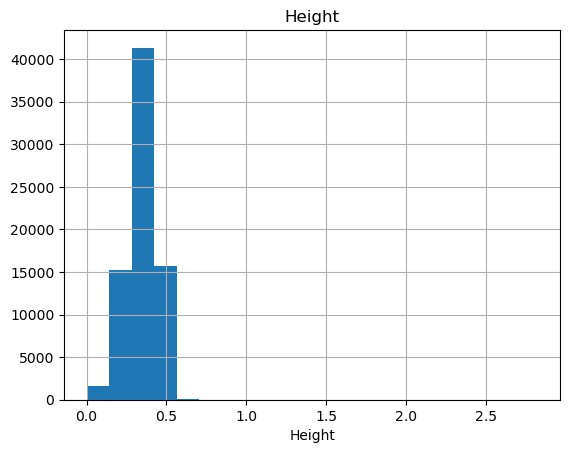

count    74051.000000
mean        23.385217
std         12.648153
min          0.056699
5%           3.600386
10%          6.109317
20%         11.169703
30%         15.450477
40%         19.575330
50%         23.799405
60%         27.158821
70%         30.830081
80%         34.458817
90%         39.136485
95%         44.211045
99%         53.438808
max         80.101512
Name: Weight, dtype: float64


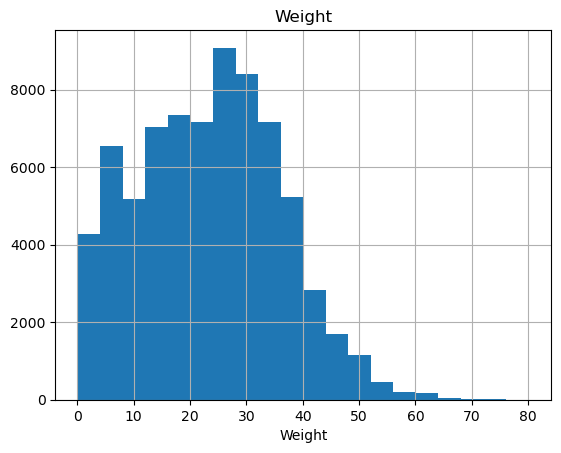

count    74051.000000
mean        10.104270
std          5.618025
min          0.028349
5%           1.502523
10%          2.636503
20%          4.776891
30%          6.676307
40%          8.320578
50%          9.908150
60%         11.623295
70%         13.253391
80%         14.926012
90%         17.293195
95%         19.376883
99%         24.309696
max         42.184056
Name: Shucked Weight, dtype: float64


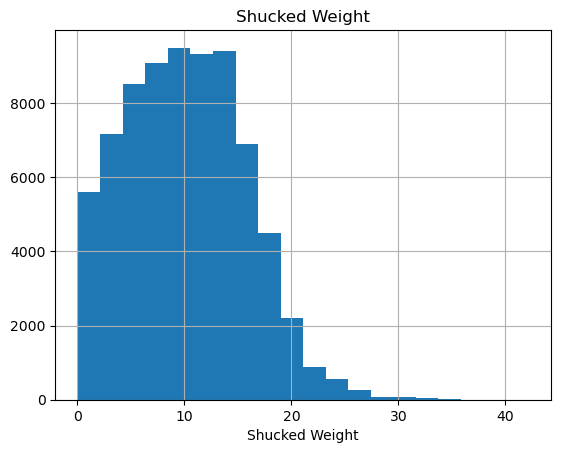

count    74051.000000
mean         5.058386
std          2.792729
min          0.042524
5%           0.793786
10%          1.289902
20%          2.353009
30%          3.302717
40%          4.195726
50%          4.989512
60%          5.839997
70%          6.619608
80%          7.470093
90%          8.632423
95%          9.738053
99%         11.793392
max         21.545620
Name: Viscera Weight, dtype: float64


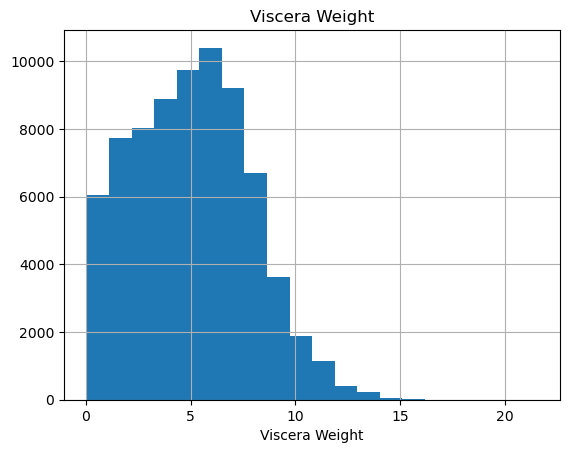

count    74051.000000
mean         6.723870
std          3.584372
min          0.042524
5%           1.105630
10%          1.956115
20%          3.260193
30%          4.535920
40%          5.669900
50%          6.931453
60%          7.796112
70%          8.703297
80%          9.780577
90%         11.297276
95%         12.743100
99%         15.677274
max         28.491248
Name: Shell Weight, dtype: float64


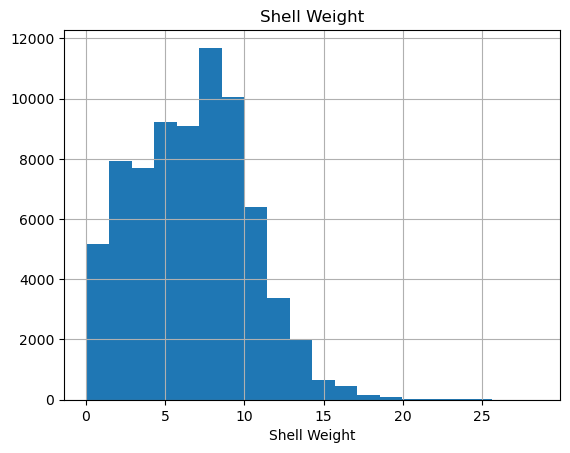

count    74051.000000
mean         9.967806
std          3.175189
min          1.000000
5%           6.000000
10%          6.000000
20%          8.000000
30%          8.000000
40%          9.000000
50%         10.000000
60%         10.000000
70%         11.000000
80%         12.000000
90%         14.000000
95%         16.000000
99%         20.000000
max         29.000000
Name: Age, dtype: float64


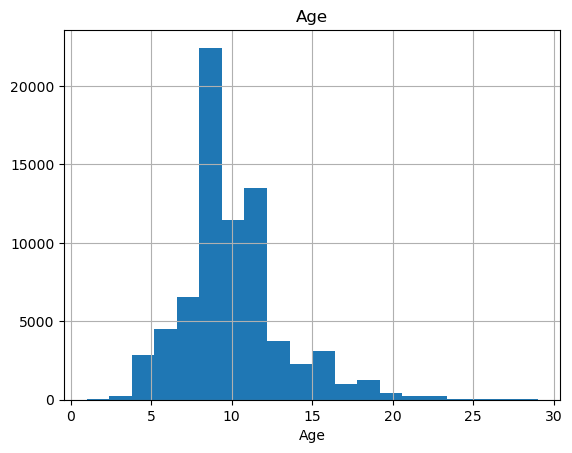

In [15]:
for col in num_cols:
    num_summary(df, col, plot=True)

In [16]:
for col in num_cols:
    target_summary_with_num(df, "Age", col)

               id
Age              
1    42832.437500
2    30485.357143
3    35935.262911
4    36283.786920
5    37431.602196
6    36978.494263
7    37054.844995
8    37150.206402
9    37080.940111
10   36811.985889
11   37024.144066
12   37186.531915
13   37057.528495
14   36264.107158
15   37890.515795
16   36951.464481
17   37682.640316
18   36306.396825
19   36347.020408
20   37630.315663
21   36363.531120
22   38120.887755
23   39187.650000
24   38520.586207
25   35371.238095
26   36832.684211
27   33336.848485
29   33568.888889


       Length
Age          
1    0.584375
2    0.622321
3    0.542840
4    0.525541
5    0.676463
6    0.880549
7    1.030197
8    1.237637
9    1.380118
10   1.451760
11   1.506615
12   1.479155
13   1.468700
14   1.465868
15   1.472127
16   1.488603
17   1.508486
18   1.519408
19   1.516837
20   1.563434
21   1.522770
22   1.514031
23   1.504479
24   1.509483
25   1.608929
26   1.548026
27   1.595076
29   1.616667


     Diameter
Age          
1    0.4

# DATA PRE-PROCESSING

In [17]:
for col in num_cols:
    if col != "Age":
        replace_with_thresholds(df,col)

for col in num_cols:
    if col != "Age":
      print(col, check_outlier(df, col))


id False
Length False
Diameter False
Height False
Weight False
Shucked Weight False
Viscera Weight False
Shell Weight False


In [18]:
check_df(df)

##################### Shape #####################
(74051, 10)
##################### Types #####################
id                  int64
Sex                object
Length            float64
Diameter          float64
Height            float64
Weight            float64
Shucked Weight    float64
Viscera Weight    float64
Shell Weight      float64
Age                 int64
dtype: object
##################### Head #####################
   id Sex  Length  Diameter  Height     Weight  Shucked Weight  \
0   0   I  1.5250    1.1750  0.3750  28.973189       12.728926   
1   1   I  1.1000    0.8250  0.2750  10.418441        4.521745   
2   2   M  1.3875    1.1125  0.3750  24.777463       11.339800   
3   3   F  1.7000    1.4125  0.5000  50.660556       20.354941   
4   4   I  1.2500    1.0125  0.3375  23.289114       11.977664   

   Viscera Weight  Shell Weight  Age  
0        6.647958      8.348928    9  
1        2.324659      3.401940    8  
2        5.556502      6.662133    9  
3       10.9

count    74051.000000
mean     37025.000000
std      21376.826729
min          0.000000
5%        3702.500000
10%       7405.000000
20%      14810.000000
30%      22215.000000
40%      29620.000000
50%      37025.000000
60%      44430.000000
70%      51835.000000
80%      59240.000000
90%      66645.000000
95%      70347.500000
99%      73309.500000
max      74050.000000
Name: id, dtype: float64


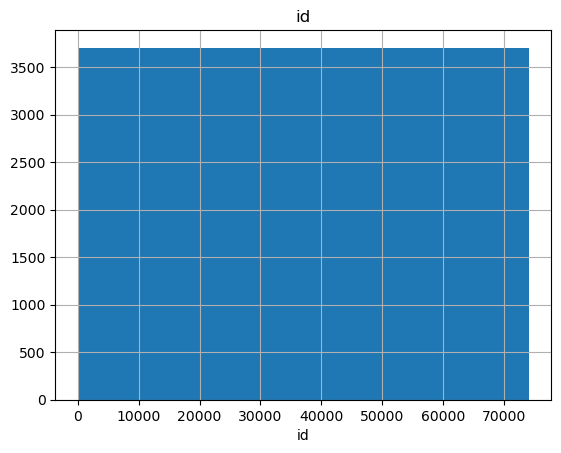

count    74051.000000
mean         1.319107
std          0.283047
min          0.568750
5%           0.737500
10%          0.900000
20%          1.087500
30%          1.200000
40%          1.300000
50%          1.375000
60%          1.437500
70%          1.500000
80%          1.562500
90%          1.625000
95%          1.675000
99%          1.787500
max          2.012815
Name: Length, dtype: float64


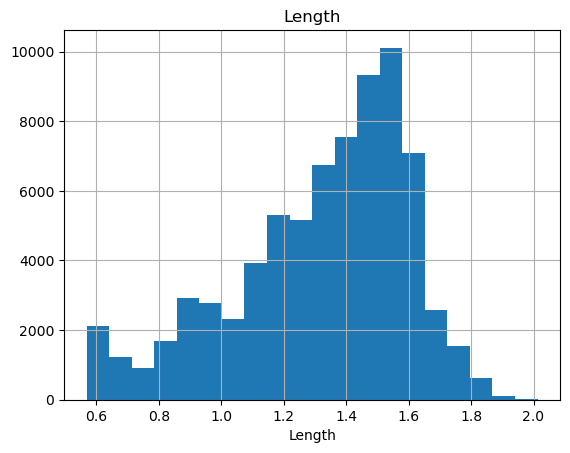

count    74051.000000
mean         1.025819
std          0.233697
min          0.418750
5%           0.550000
10%          0.675000
20%          0.837500
30%          0.937500
40%          1.000000
50%          1.075000
60%          1.125000
70%          1.187500
80%          1.225000
90%          1.287500
95%          1.312500
99%          1.412500
max          1.612500
Name: Diameter, dtype: float64


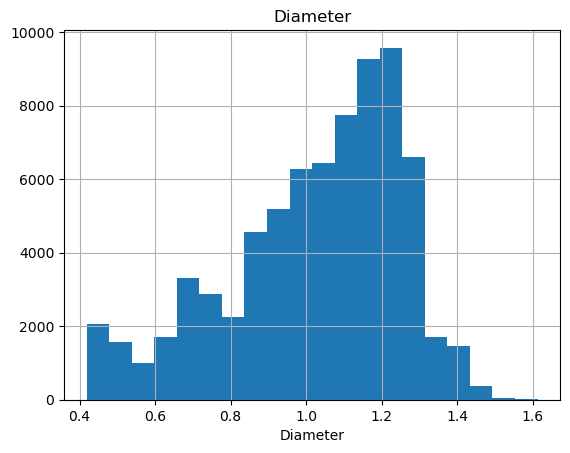

count    74051.000000
mean         0.348498
std          0.089664
min          0.131250
5%           0.187500
10%          0.225000
20%          0.262500
30%          0.312500
40%          0.337500
50%          0.362500
60%          0.387500
70%          0.400000
80%          0.425000
90%          0.450000
95%          0.475000
99%          0.525000
max          0.581250
Name: Height, dtype: float64


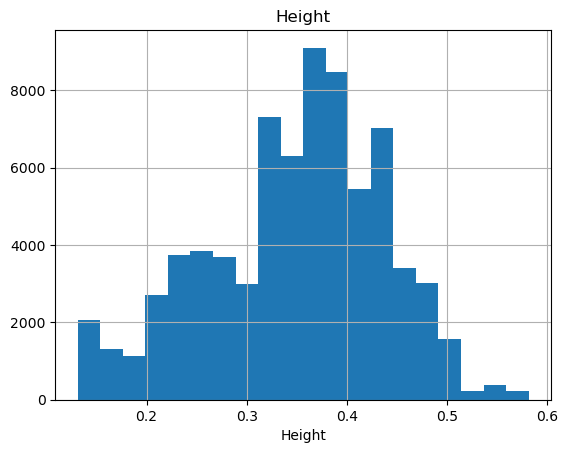

count    74051.000000
mean        23.370305
std         12.599403
min          0.056699
5%           3.600386
10%          6.109317
20%         11.169703
30%         15.450477
40%         19.575330
50%         23.799405
60%         27.158821
70%         30.830081
80%         34.458817
90%         39.136485
95%         44.211045
99%         53.438808
max         60.249775
Name: Weight, dtype: float64


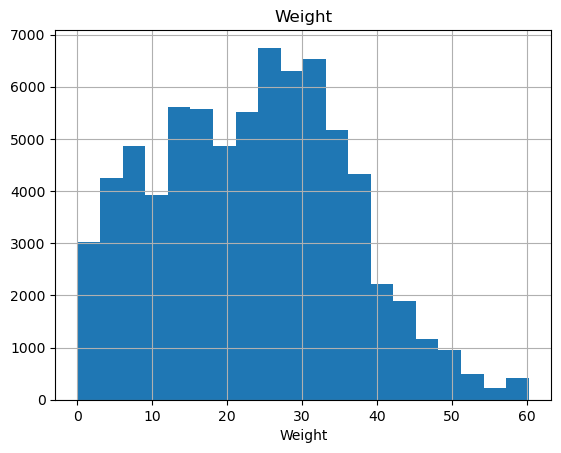

count    74051.000000
mean        10.090120
std          5.569390
min          0.028349
5%           1.502523
10%          2.636503
20%          4.776891
30%          6.676307
40%          8.320578
50%          9.908150
60%         11.623295
70%         13.253391
80%         14.926012
90%         17.293195
95%         19.376883
99%         24.309696
max         26.513870
Name: Shucked Weight, dtype: float64


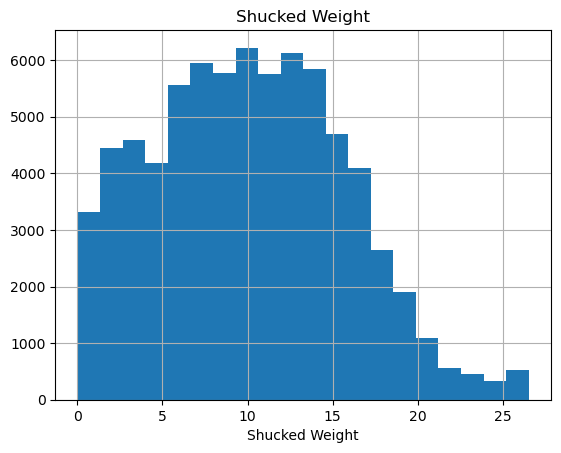

count    74051.000000
mean         5.055009
std          2.781576
min          0.042524
5%           0.793786
10%          1.289902
20%          2.353009
30%          3.302717
40%          4.195726
50%          4.989512
60%          5.839997
70%          6.619608
80%          7.470093
90%          8.632423
95%          9.738053
99%         11.793392
max         13.175430
Name: Viscera Weight, dtype: float64


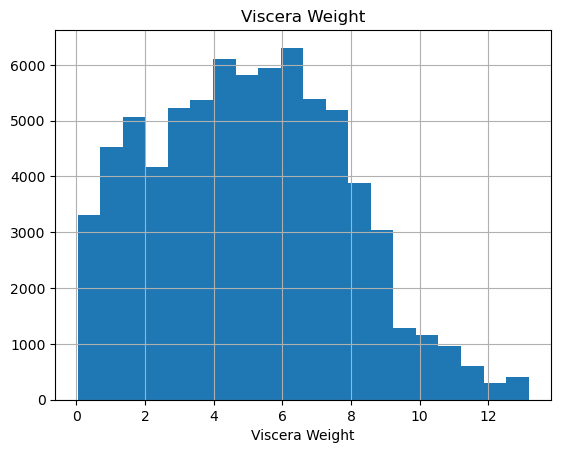

count    74051.000000
mean         6.714560
std          3.553274
min          0.042524
5%           1.105630
10%          1.956115
20%          3.260193
30%          4.535920
40%          5.669900
50%          6.931453
60%          7.796112
70%          8.703297
80%          9.780577
90%         11.297276
95%         12.743100
99%         15.677274
max         16.726205
Name: Shell Weight, dtype: float64


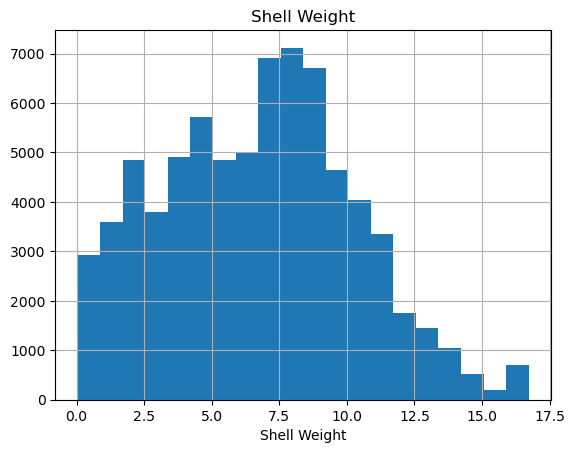

count    74051.000000
mean         9.967806
std          3.175189
min          1.000000
5%           6.000000
10%          6.000000
20%          8.000000
30%          8.000000
40%          9.000000
50%         10.000000
60%         10.000000
70%         11.000000
80%         12.000000
90%         14.000000
95%         16.000000
99%         20.000000
max         29.000000
Name: Age, dtype: float64


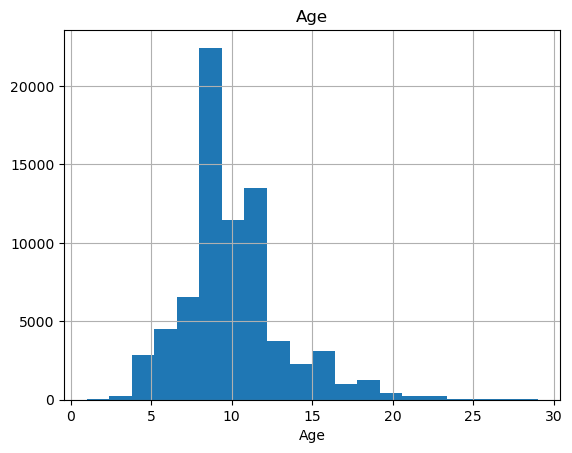

In [19]:
for col in num_cols:
    num_summary(df, col, plot=True)

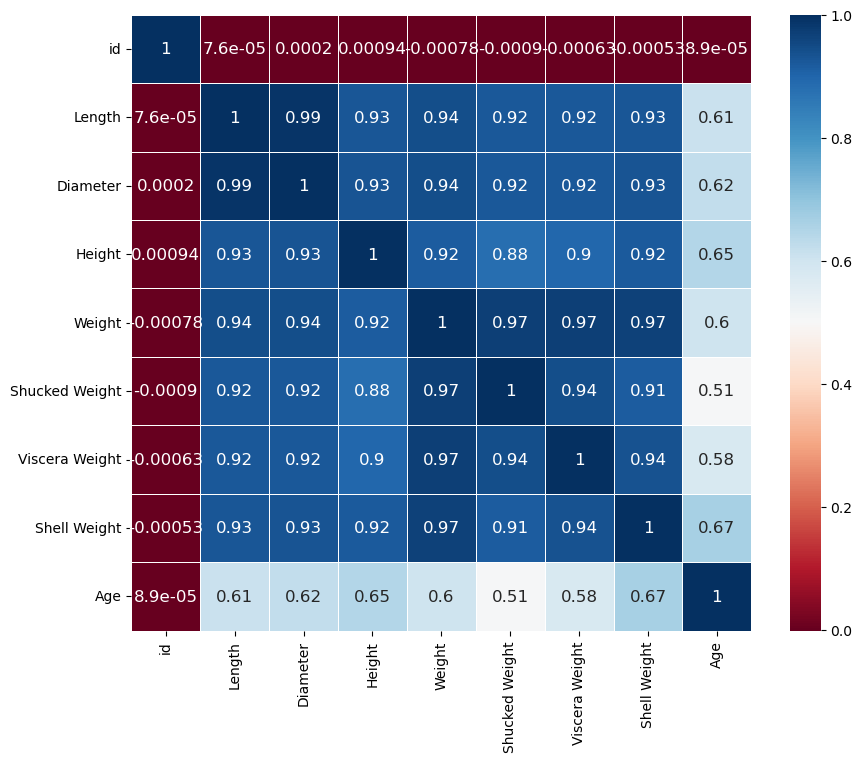

In [20]:
correlation_matrix(df, num_cols)

# 2. DATA PRE-PROCESSING

In [21]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

In [22]:
for col in num_cols:
    if col != "Age":
        replace_with_thresholds(df,col)

for col in num_cols:
    if col != "Age":
      print(col, check_outlier(df, col))

id False
Length False
Diameter False
Height False
Weight False
Shucked Weight False
Viscera Weight False
Shell Weight False


In [23]:
y = df["Age"]
X = df.drop(["Age","id"], axis=1)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
num_cols

['id',
 'Length',
 'Diameter',
 'Height',
 'Weight',
 'Shucked Weight',
 'Viscera Weight',
 'Shell Weight',
 'Age']

# 3. HYPERPARAMETER OPTIMIZATION

In [26]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

[I 2023-06-09 08:40:21,198] A new study created in memory with name: no-name-c588ba24-29aa-49f4-bae1-021d6648b59f
[I 2023-06-09 08:40:25,429] Trial 0 finished with value: 1.4032192841764244 and parameters: {'max_depth': 4, 'early_stopping_rounds': 255, 'scale_pos_weight': 8.753523981678793, 'learning_rate': 0.09381494592807932, 'subsample': 0.6331964339246292, 'colsample_bytree': 0.5813699898146654, 'colsample_bynode': 0.8055414541213046, 'num_iterations': 1249, 'num_leaves': 336}. Best is trial 0 with value: 1.4032192841764244.
[I 2023-06-09 08:41:02,120] Trial 1 finished with value: 1.4095535118018525 and parameters: {'max_depth': 18, 'early_stopping_rounds': 275, 'scale_pos_weight': 12.508677762095667, 'learning_rate': 0.013877951181505732, 'subsample': 0.6089794464594938, 'colsample_bytree': 0.8688272035574622, 'colsample_bynode': 0.8354906105536555, 'num_iterations': 532, 'num_leaves': 415}. Best is trial 0 with value: 1.4032192841764244.
[I 2023-06-09 08:41:15,186] Trial 2 finish

In [27]:
params = study.best_params

# 4. FINAL MODEL

In [28]:
params = study.best_params
lgb_final = LGBMRegressor(**params).fit(X_train, y_train, eval_set=(X_test, y_test), eval_metric="mse", 
                                         verbose=-99)

[LightGBM] [Warning] early_stopping_round is set=138, early_stopping_rounds=138 will be ignored. Current value: early_stopping_round=138


In [29]:
y_pred = lgb_final.predict(X_test)

In [30]:
print("R2 score  :",r2_score(y_test, y_pred))
print("MAE score  :",mean_absolute_error(y_test, y_pred))

R2 score  : 0.5930552441588501
MAE score  : 1.4043001400150719


# 5.IMPORTANCE VARIABLES

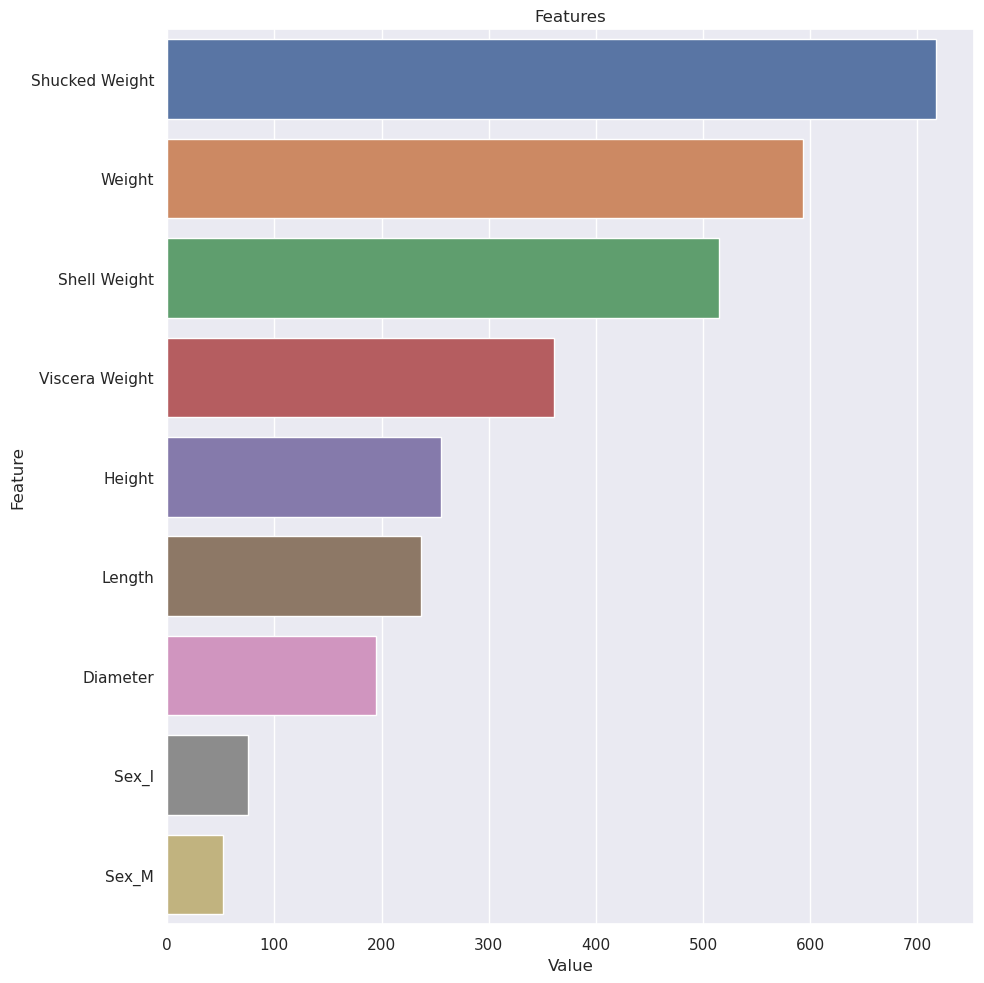

In [31]:
def plot_importance(model, features, num=len(X), save=False):

    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")

model = LGBMRegressor()
model.fit(X, y)

plot_importance(model, X, num=30)